In [134]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [135]:
block_size = 3
X, Y = [], []
for w in words:
#     print(w)
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [136]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [231]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 4]) torch.Size([182441])
torch.Size([22902, 4]) torch.Size([22902])
torch.Size([22803, 4]) torch.Size([22803])


In [238]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator = g)

W1 = torch.randn((40, 200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [233]:
sum(p.nelement() for p in parameters)

11897

In [239]:
for p in parameters:
    p.requires_grad = True

In [241]:
lri = []
lossi = []
stepi = []

In [242]:


for i in range(200000):
    
    #minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 40) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
#backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
# update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
#track stats
#     lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)
        

print(loss.item())

1.904803991317749


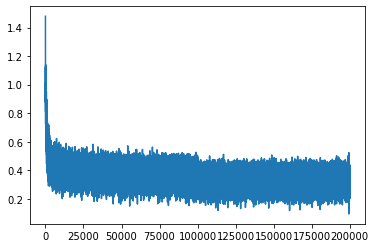

In [243]:
plt.plot(stepi, lossi)

In [245]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 40) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.18852162361145

In [246]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 40) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.138517379760742

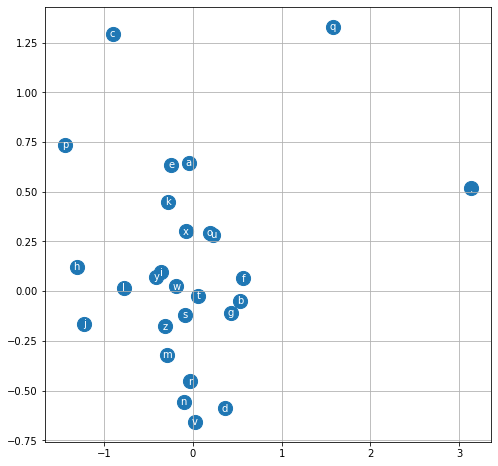

In [230]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [247]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amille.
khiigrey.
taty.
skanden.
jazonte.
densyn.
jarque.
nelene.
tceriir.
kaleigh.
hama.
kinder.
juna.
line.
live.
quintero.
dearynn.
jacei.
dusti.
